In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import torch
import os
from PIL import Image
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn.functional as F 

In [2]:
import torchvision.models as models
model = models.resnet34(pretrained=True)
model.fc = nn.Sequential(nn.Linear(512, 345))


In [3]:
# maynot useful 
class FocalLoss2d(nn.modules.loss._WeightedLoss):

    def __init__(self, gamma=2, weight=None, size_average=None, ignore_index=-100,
                 reduce=None, reduction='mean', balance_param=0.25):
        super(FocalLoss2d, self).__init__(weight, size_average, reduce, reduction)
        self.gamma = gamma
        self.weight = weight
        self.size_average = size_average
        self.ignore_index = ignore_index
        self.balance_param = balance_param

    def forward(self, input, target):
        
        # inputs and targets are assumed to be BatchxClasses
        assert len(input.shape) == len(target.shape)
        assert input.size(0) == target.size(0)
        assert input.size(1) == target.size(1)
        
        weight = Variable(self.weight)
           
        # compute the negative likelyhood
        logpt = - F.binary_cross_entropy_with_logits(input, target, pos_weight=weight, reduction=self.reduction)
        pt = torch.exp(logpt)

        # compute the loss
        focal_loss = -( (1-pt)**self.gamma ) * logpt
        balanced_focal_loss = self.balance_param * focal_loss
        return balanced_focal_loss



In [4]:
# Setup: initialize the hyperparameters/variables
# Setup: initialize the hyperparameters/variables
num_epochs = 10           # Number of full passes through the dataset
batch_size = 128         # Number of samples in each minibatch
learning_rate = 0.01  
seed = np.random.seed(0) # Seed the random number generator for reproducibility
p_val = 0.1              # Percent of the overall dataset to reserve for validation
p_test = 0.2             # Percent of the overall dataset to reserve for testing


#TODO: Convert to Tensor - you can later add other transformations, such as Scaling here

transform = transforms.Compose([
        #transforms.RandomResizedCrop(224),
        transforms.ToPILImage('L'),
        transforms.Resize([224,224],interpolation=2),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])


In [5]:

# Check if your system supports CUDA
use_cuda = torch.cuda.is_available()

# Setup GPU optimization if CUDA is supported
if use_cuda:
    computing_device = torch.device("cuda")
    extras = {"num_workers": 1, "pin_memory": True}
    print("CUDA is supported")
else: # Otherwise, train on the CPU
    computing_device = torch.device("cpu")
    extras = False
    print("CUDA NOT supported")

model = model
model = model.to(computing_device)
print("Model on CUDA?", next(model.parameters()).is_cuda)    

CUDA is supported
Model on CUDA? True


In [6]:
### need to modify
# Setup the training, validation, and testing dataloaders
import quickdraw_dataloader as qd
from quickdraw_dataloader import create_split_loaders
root_dir = "./data_subset/"
train_loader, val_loader, test_loader = create_split_loaders(root_dir,batch_size, seed, transform=transform, 
                                                             p_val=p_val, p_test=p_test,
                                                             shuffle=True, show_sample=False, 
                                                             extras=extras)


In [7]:
criterion = nn.CrossEntropyLoss().to(computing_device)

optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0001)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [8]:
def validate(val_loader,model,optimizer):
    start = time.time()
    sum_loss = 0.0
    list_sum_loss = []
    num = 0
    for mb_count, (val_images, val_labels) in enumerate(val_loader, 0):
        model.eval()
        with torch.no_grad():  
            optimizer.zero_grad()      
            val_images = torch.squeeze(torch.stack([val_images,val_images,val_images], dim=1, out=None))
            val_images, val_labels = val_images.to(computing_device), val_labels.to(computing_device)
            val_labels = val_labels.type(torch.cuda.FloatTensor)
            outputs = model(val_images)
            loss = criterion(outputs,torch.max(val_labels, 1)[1])
            sum_loss += loss
            output_np = outputs.cpu().detach().numpy()
            label_np = val_labels.cpu().detach().numpy()

            accuracy_train = accuracy(label_np, output_np)
            print('validation accuracy',accuracy_train)
    print("validation time = ", time.time()-start)    
    return 1.0*sum_loss/mb_count  

In [9]:
def accuracy(out, labels):
    outputs = np.argmax(out, axis=1)
    lab = np.argmax(labels, axis=1)
    return np.sum(outputs==lab)/float(lab.size)

In [10]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()
    total_loss = []
    avg_minibatch_loss = []
    total_vali_loss = []
    tolerence = 3
    i = 0 
    for epoch in range(num_epochs):
        N = 100
        M = 100
        N_minibatch_loss = 0.0    
        best_loss = 100
        early_stop = 0
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train']:
            scheduler.step()
            # Iterate over data.
            for minibatch_count, (inputs, labels) in enumerate(train_loader, 0):
                inputs = torch.squeeze(torch.stack([inputs,inputs,inputs], dim=1, out=None))
                inputs = inputs.to(computing_device)
                labels = labels.to(computing_device)
                labels = labels.long()
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    labels = labels.long()
                    loss = criterion(outputs,torch.max(labels, 1)[1])
                    #loss = criterion(torch.max(outputs,1)[1],torch.max(labels, 1)[1])
                    N_minibatch_loss += loss
                    # backward + optimize only if in training phase
                    loss.backward()
                    optimizer.step()
                
                # statistics
                # training stats
                if minibatch_count % N == 0 and minibatch_count!=0:    

                    # Print the loss averaged over the last N mini-batches    
                    N_minibatch_loss /= N
                    print('Epoch %d, average minibatch %d loss: %.3f' %
                        (epoch + 1, minibatch_count, N_minibatch_loss))

                    # Add the averaged loss over N minibatches and reset the counter
                    avg_minibatch_loss.append(N_minibatch_loss)
                    
                    avg_minibatch_loss_1 = np.array(avg_minibatch_loss)
                    np.save('avg_minibatch_loss_new', avg_minibatch_loss_1)
                    
                    N_minibatch_loss = 0.0

                    output_np = outputs.cpu().detach().numpy()
                    label_np = labels.cpu().detach().numpy()

                    accuracy_train = accuracy(label_np, output_np)
                    print('accuracy',accuracy_train)
                    #print('accuracy, precision, recall', accuracy, precision, recall)
                
                #Validation
                if minibatch_count % M == 0 and minibatch_count!=0: 
                    #model = torch.load('./checkpoint')
                    save_checkpoint({'epoch': epoch + 1,
                                'state_dict': model.state_dict(),
                                'optimizer': optimizer.state_dict(),
                                },
                                filename='./checkpoint/'+'%d_model_epoch%d.pth' % (epoch , minibatch_count))
                    v_loss = validate(val_loader,model,optimizer).item()
                    print(v_loss)
                    total_vali_loss.append(v_loss)

                    total_vali_loss_1 = np.array(total_vali_loss)
                    np.save('total_vali_loss_new', total_vali_loss_1)                    

                    if total_vali_loss[i] > best_loss and i != 0:
                        early_stop += 1
                        if early_stop == tolerence:
                            print('early stop here')
                            break
                    else:
                        best_loss = total_vali_loss[i] 
                        early_stop = 0
                    i = i + 1
            print("Finished", epoch + 1, "epochs of training")
    print("Training complete after", epoch, "epochs")
    
    avg_minibatch_loss = np.array(avg_minibatch_loss)
    np.save('avg_minibatch_loss_new', avg_minibatch_loss)

    total_vali_loss = np.array(total_vali_loss)
    np.save('total_vali_loss_new', total_vali_loss)  
    print("total_vali_loss")
    print(total_vali_loss)
    print("avg_minibatch_loss")
    print(avg_minibatch_loss)
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s '.format(
        time_elapsed // 60, time_elapsed % 60))


In [11]:
def save_checkpoint(state, is_best=0, filename='models/checkpoint.pth.tar'):
    torch.save(state, filename)


In [ ]:
model_trained = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=5)


Epoch 0/4
----------
Epoch 1, average minibatch 100 loss: 5.002
accuracy 0.25
validation time =  378.2949752807617
4.012600898742676
Epoch 1, average minibatch 200 loss: 3.172
accuracy 0.3671875
validation time =  370.81581687927246
2.6819586753845215
Epoch 1, average minibatch 300 loss: 2.461
accuracy 0.34375
validation time =  379.2652356624603
2.3439958095550537
Epoch 1, average minibatch 400 loss: 2.246
accuracy 0.46875
validation time =  397.8659565448761
2.218594551086426
Epoch 1, average minibatch 500 loss: 2.067
accuracy 0.546875
validation time =  408.72339630126953
2.0304555892944336
Epoch 1, average minibatch 600 loss: 2.016
accuracy 0.578125


torch.Size([128, 1, 224, 224])
-16333069.0


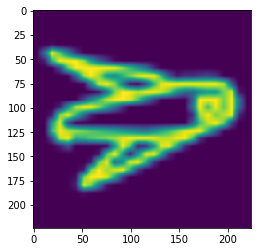

-15532964.0


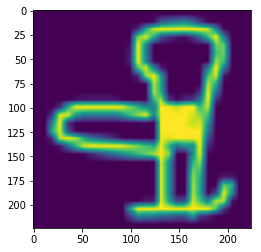

-17674116.0


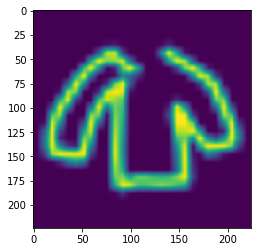

-20291602.0


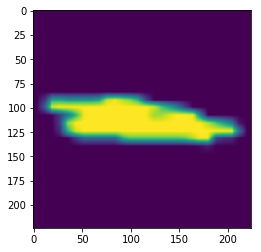

torch.Size([128, 1, 224, 224])
-15266640.0


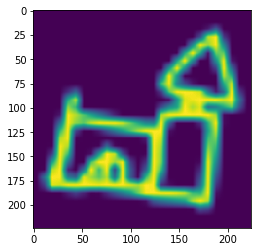

-17990920.0


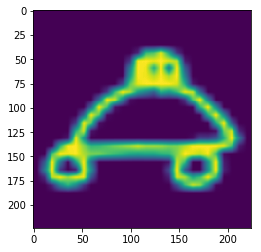

-20528350.0


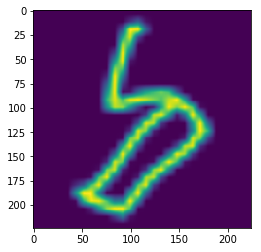

-14179391.0


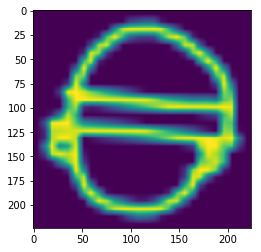

torch.Size([128, 1, 224, 224])
-18785244.0


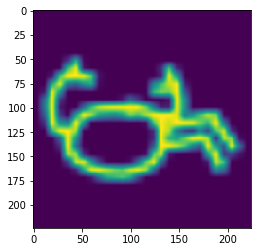

-12678151.0


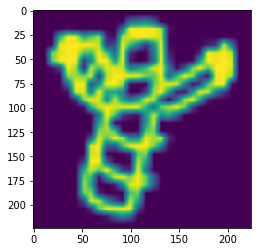

-12917277.0


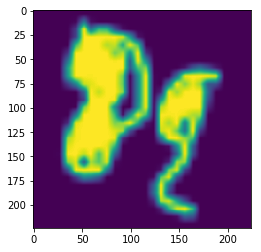

-14919041.0


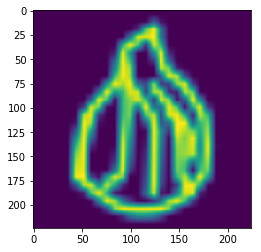

torch.Size([128, 1, 224, 224])
-18833628.0


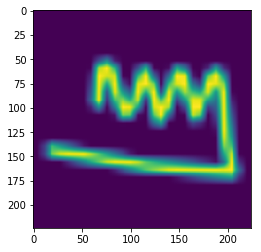

-20677280.0


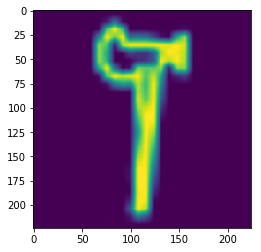

-17906850.0


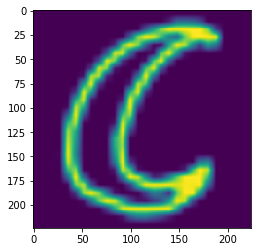

-17501976.0


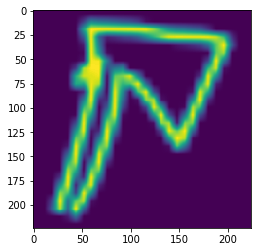

torch.Size([128, 1, 224, 224])
-18659112.0


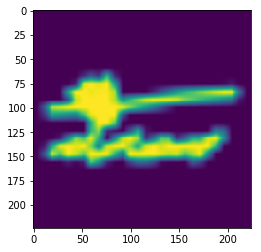

-15129593.0


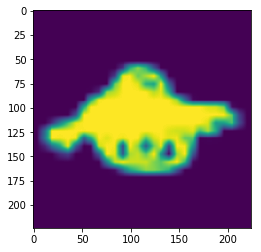

-16754133.0


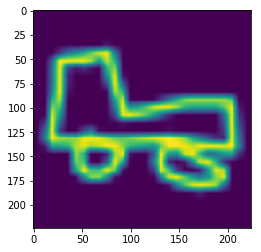

-18926848.0


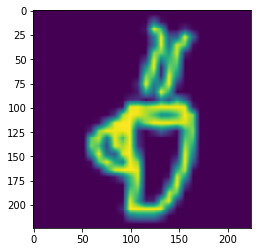

torch.Size([128, 1, 224, 224])
-20001104.0


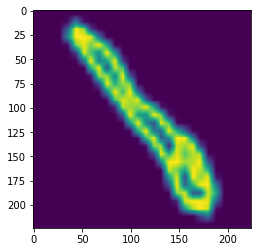

-20911042.0


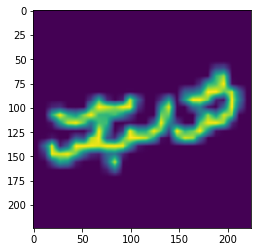

-17947236.0


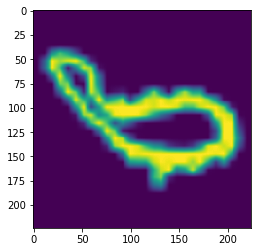

-15503968.0


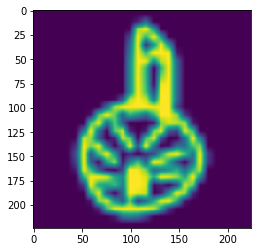

torch.Size([128, 1, 224, 224])
-16442501.0


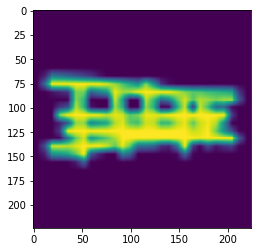

-11436143.0


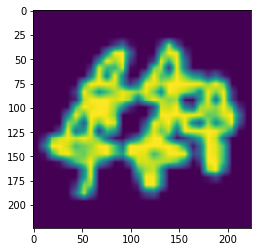

-17081734.0


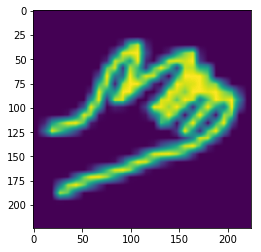

-12744912.0


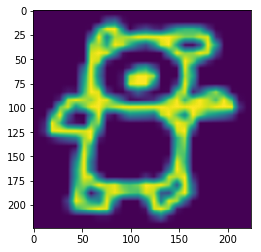

torch.Size([128, 1, 224, 224])
-18580280.0


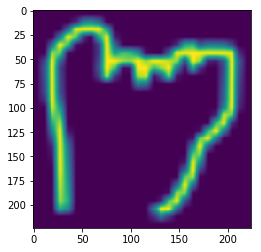

-13073750.0


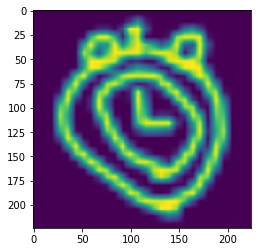

-16593801.0


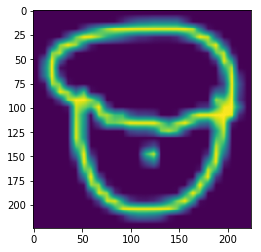

-20177088.0


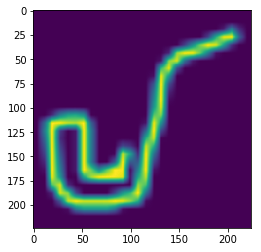

torch.Size([128, 1, 224, 224])
-16236562.0


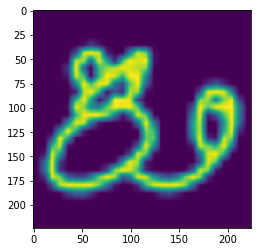

-17802152.0


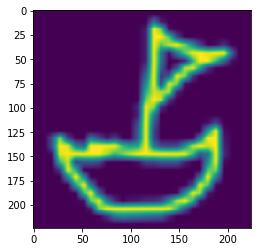

-22706344.0


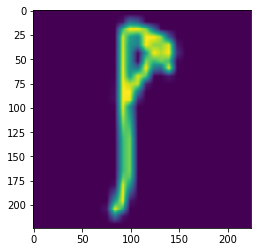

-16788842.0


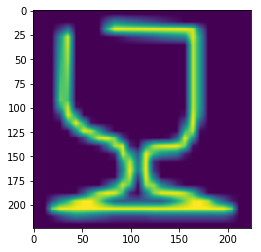

torch.Size([128, 1, 224, 224])
-16387653.0


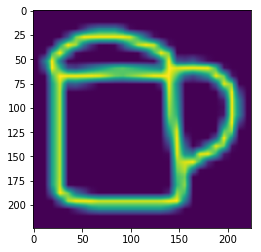

-19486502.0


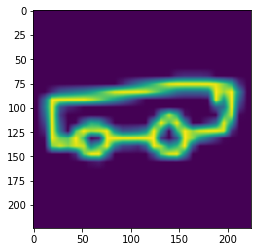

-19112966.0


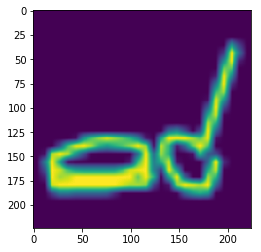

-15186920.0


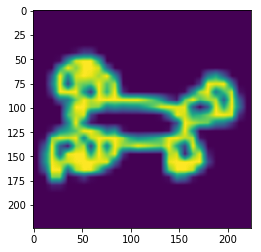

torch.Size([128, 1, 224, 224])
-13560283.0


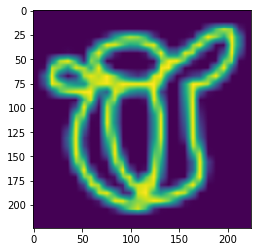

-17083742.0


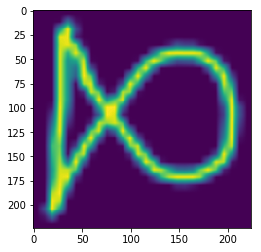

-18739844.0


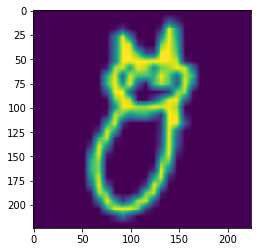

-20719394.0


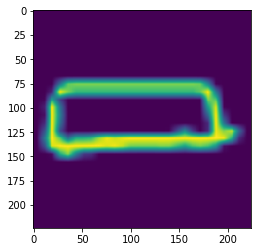

torch.Size([128, 1, 224, 224])
-18362466.0


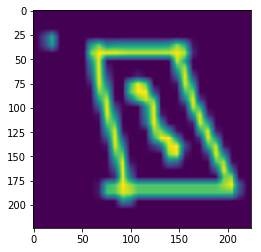

-10172055.0


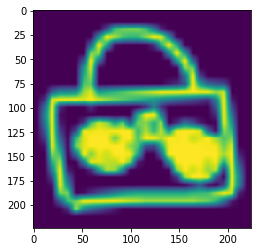

-17939724.0


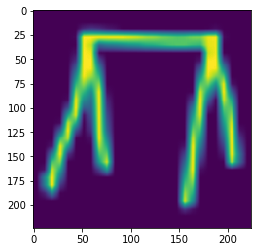

-17046554.0


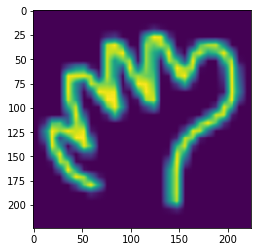

In [14]:
# import matplotlib.pyplot as plt
# from IPython.display import display # to display images
# for minibatch_count, (inputs, labels) in enumerate(train_loader, 0):
#     print(inputs.shape)
#     #inputs = inputs.to(computing_device)
#     #labels = labels.to(computing_device)
#     image = inputs.cpu().detach().numpy()[1].reshape((224,224))*255
    
#     print(image.sum())
#     plt.imshow(image.astype(int),)
#     plt.show()
#     image = inputs.cpu().detach().numpy()[0].reshape((224,224))*255
    
#     print(image.sum())
#     plt.imshow(image.astype(int),)
#     plt.show()
#     image = inputs.cpu().detach().numpy()[2].reshape((224,224))*255
    
#     print(image.sum())
#     plt.imshow(image.astype(int),)
#     plt.show()
    
#     image = inputs.cpu().detach().numpy()[3].reshape((224,224))*255
    
#     print(image.sum())
#     plt.imshow(image.astype(int),)
#     plt.show()
#     #image = Image.fromarray(image.astype(int),"L")
#     #display(image)
#     if minibatch_count >10: 
#         break
    

In [ ]:
# >>> loss = nn.CrossEntropyLoss()
# >>> input = torch.randn(3, 5, requires_grad=True)
# >>> target = torch.empty(3, dtype=torch.long).random_(5)
# >>> output = loss(input, target)
# >>> output.backward()

In [ ]:
# input